##### Copyright 2019 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [1]:
# Copyright 2019 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS, 
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# Bangla Article Classification With TF-Hub

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/hub/tutorials/bangla_article_classifier"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/bangla_article_classifier.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/hub/blob/master/examples/colab/bangla_article_classifier.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/hub/examples/colab/bangla_article_classifier.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

Caution: In addition to installing python packages with pip, this notebook uses
`sudo apt install` to install system packages: `unzip`.

This colab is a demonstration of using [Tensorflow Hub](https://www.tensorflow.org/hub/) for text classification in non-English/local languages. Here we choose [Bangla](https://en.wikipedia.org/wiki/Bengali_language) as the local language and use pretrained word embeddings to solve a multiclass classification task where we classify Bangla news articles in 5 categories.  The pretrained embeddings for Bangla comes from [fastText](https://fasttext.cc/docs/en/crawl-vectors.html) which is a library by Facebook with released pretrained word vectors for 157 languages. 

We'll use TF-Hub's pretrained embedding exporter for converting the word embeddings to a text embedding module first and then use the module to train a classifier with [tf.keras](https://www.tensorflow.org/api_docs/python/tf/keras), Tensorflow's high level user friendly API to build deep learning models.  Even if we are using fastText embeddings here, it's possible to export any other embeddings pretrained from other tasks and quickly get results with Tensorflow hub. 

## Setup

In [2]:
%%bash
# https://github.com/pypa/setuptools/issues/1694#issuecomment-466010982
pip install -q gdown --no-use-pep517

In [3]:
%%bash
sudo apt-get install -y unzip

Reading package lists...
Building dependency tree...
Reading state information...
unzip is already the newest version (6.0-21ubuntu1).
The following packages were automatically installed and are no longer required:
  dconf-gsettings-backend dconf-service dkms freeglut3 freeglut3-dev
  glib-networking glib-networking-common glib-networking-services
  gsettings-desktop-schemas libcairo-gobject2 libcolord2 libdconf1
  libegl1-mesa libepoxy0 libglu1-mesa libglu1-mesa-dev libgtk-3-0
  libgtk-3-common libice-dev libjansson4 libjson-glib-1.0-0
  libjson-glib-1.0-common libproxy1v5 librest-0.7-0 libsm-dev
  libsoup-gnome2.4-1 libsoup2.4-1 libwayland-cursor0 libwayland-egl1 libxfont2
  libxi-dev libxkbcommon0 libxkbfile1 libxmu-dev libxmu-headers libxnvctrl0
  libxt-dev linux-gcp-headers-5.0.0-1026 linux-headers-5.0.0-1026-gcp
  linux-image-5.0.0-1026-gcp linux-modules-5.0.0-1026-gcp pkg-config
  policykit-1-gnome python3-xkit screen-resolution-extra x11-xkb-utils
  xserver-common xserver-xorg-

In [4]:
import os

import tensorflow as tf
import tensorflow_hub as hub

import gdown
import numpy as np
from sklearn.metrics import classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# Dataset

We will use [BARD](https://www.researchgate.net/publication/328214545_BARD_Bangla_Article_Classification_Using_a_New_Comprehensive_Dataset) (Bangla Article Dataset) which has around 3,76,226 articles collected from different Bangla news portals and labelled with 5 categories : economy, state, international, sports and entertainment. We download the file from Google Drive this ([bit.ly/BARD_DATASET](bit.ly/BARD_DATASET)) link is referring to from [this](https://github.com/tanvirfahim15/BARD-Bangla-Article-Classifier) GitHub repository.


In [5]:
gdown.download(
    url='https://drive.google.com/uc?id=1Ag0jd21oRwJhVFIBohmX_ogeojVtapLy',
    output='bard.zip',
    quiet=True
)

'bard.zip'

In [6]:
%%bash
unzip -qo bard.zip

# Export pretrained word vectors to TF-Hub module

TF-Hub provides some handy scripts for converting word embeddings to TF-hub text embedding modules [here](https://github.com/tensorflow/hub/tree/master/examples/text_embeddings_v2). To make the module for Bangla or any other languages we simply have to download the word embedding .txt or .vec file to the same directory as export_v2.py and run the script.


The exporter reads the embedding vectors and exports it to a Tensorflow [SavedModel](https://www.tensorflow.org/beta/guide/saved_model). A SavedModel contains a complete TensorFlow program including weights and graph. TF-Hub can load the SavedModel as a [module](https://www.tensorflow.org/hub/api_docs/python/hub/Module) which we will use to build the model for text classification. Since we are using tf.keras to build the model we will use [hub.KerasLayer](https://www.tensorflow.org/hub/api_docs/python/hub/KerasLayer) which provides a wrapper for a hub module to use as a Keras Layer.

First we will get our word embeddings from fastText and embedding exporter from TF-Hub [repo](https://github.com/tensorflow/hub).


In [7]:
%%bash
curl -O https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.bn.300.vec.gz
curl -O https://raw.githubusercontent.com/tensorflow/hub/master/examples/text_embeddings_v2/export_v2.py
gunzip -qf cc.bn.300.vec.gz --k

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  840M  100  840M    0     0  13.2M      0  0:01:03  0:01:03 --:--:-- 13.8M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  7493  100  7493    0     0  16396      0 --:--:-- --:--:-- --:--:-- 16360


Then we will run the exporter script on our embedding file. Since fastText embeddings has a header line and are pretty large(around 3.3 GB for bangla after converting to a module) we ignore the first line and export only the first 100, 000 tokens to the text embedding module.

In [8]:
%%bash
python export_v2.py --embedding_file=cc.bn.300.vec --export_path=text_module --num_lines_to_ignore=1 --num_lines_to_use=100000

2020-11-24 16:38:16.506111: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-11-24 16:38:30.883816: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcuda.so.1
2020-11-24 16:38:31.588580: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:982] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2020-11-24 16:38:31.589356: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1716] Found device 0 with properties: 
pciBusID: 0000:00:05.0 name: Tesla V100-SXM2-16GB computeCapability: 7.0
coreClock: 1.53GHz coreCount: 80 deviceMemorySize: 15.78GiB deviceMemoryBandwidth: 836.37GiB/s
2020-11-24 16:38:31.589426: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
2020-11-24 16:38:31.591384: I tensorflow/stream_executor/plat

In [9]:
module_path = "text_module"
embedding_layer = hub.KerasLayer(module_path, trainable=False)

The text embedding module takes a batch of sentences in a 1D tensor of strings as input and outputs the embedding vectors of shape (batch_size, embedding_dim) corresponding to the sentences. It preprocesses the input by splitting on spaces. Word embeddings are combined to sentence embeddings with the `sqrtn` combiner(See [here](https://www.tensorflow.org/api_docs/python/tf/nn/embedding_lookup_sparse)). For demonstration we pass a list of Bangla words as input and get the corresponding embedding vectors.

In [10]:
embedding_layer(['বাস', 'বসবাস', 'ট্রেন', 'যাত্রী', 'ট্রাক']) 

<tf.Tensor: shape=(5, 300), dtype=float64, numpy=
array([[ 0.0462, -0.0355,  0.0129, ...,  0.0025, -0.0966,  0.0216],
       [-0.0631, -0.0051,  0.085 , ...,  0.0249, -0.0149,  0.0203],
       [ 0.1371, -0.069 , -0.1176, ...,  0.029 ,  0.0508, -0.026 ],
       [ 0.0532, -0.0465, -0.0504, ...,  0.02  , -0.0023,  0.0011],
       [ 0.0908, -0.0404, -0.0536, ..., -0.0275,  0.0528,  0.0253]])>

# Convert to Tensorflow Dataset 


Since the dataset is really large instead of loading the entire dataset in memory we will use a generator to yield samples in run-time in batches using [Tensorflow Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) functionalities.  The dataset is also very imbalanced, so before using the generator we will shuffle the dataset. 


In [11]:
dir_names = ['economy', 'sports', 'entertainment', 'state', 'international']

file_paths = []
labels = []
for i, dir in enumerate(dir_names):
  file_names = ["/".join([dir, name]) for name in os.listdir(dir)]
  file_paths += file_names
  labels += [i] * len(os.listdir(dir))
  
np.random.seed(42)
permutation = np.random.permutation(len(file_paths))

file_paths = np.array(file_paths)[permutation]
labels = np.array(labels)[permutation]

We can check the distribution of labels in the training and validation examples after shuffling.

In [12]:
train_frac = 0.8
train_size = int(len(file_paths) * train_frac)

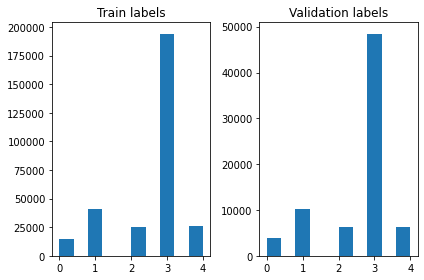

In [13]:
# plot training vs validation distribution
plt.subplot(1, 2, 1)
plt.hist(labels[0:train_size])
plt.title("Train labels")
plt.subplot(1, 2, 2)
plt.hist(labels[train_size:])
plt.title("Validation labels")
plt.tight_layout()

To create a [Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset) using generator we first write a generator function which reads each of the articles from file_paths and the labels from the label array, and yields one training example at each step. We pass this generator function to the [tf.data.Dataset.from_generator](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#from_generator) method and specify the output types. Each training example is a tuple containing an article of tf.string data type and one-hot encoded label. We split the dataset with a train-validation split of 80-20 using the [`skip`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#skip) and [`take`](https://www.tensorflow.org/api_docs/python/tf/data/Dataset#take) method.

In [14]:
def load_file(path, label):
    return tf.io.read_file(path), label

In [15]:
def make_datasets(train_size):
  batch_size = 256

  train_files = file_paths[:train_size]
  train_labels = labels[:train_size]
  train_ds = tf.data.Dataset.from_tensor_slices((train_files, train_labels))
  train_ds = train_ds.map(load_file).shuffle(5000)
  train_ds = train_ds.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)

  test_files = file_paths[train_size:]
  test_labels = labels[train_size:]
  test_ds = tf.data.Dataset.from_tensor_slices((test_files, test_labels))
  test_ds = test_ds.map(load_file)
  test_ds = test_ds.batch(batch_size).prefetch(tf.data.experimental.AUTOTUNE)


  return train_ds, test_ds

In [16]:
train_data, validation_data = make_datasets(train_size)

# Model Training and Evaluation

Since we have already added a wrapper around our module to use it as any other layer in keras we can create a small [Sequential](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) model which is a linear stack of layers. We can add our text embedding module with `model.add` just like any other layer. We compile the model by specifying the loss and optimizer and train it for 10 epochs. `tf.keras` API can handle tensorflow datasets as input, so we can pass a Dataset instance to the fit method for model training. Since we are using a generator function, tf.data will handle generating the samples, batching them and feeding them to the model.

## Model

In [17]:
def create_model():
  model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=[], dtype=tf.string),
    embedding_layer,
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(16, activation="relu"),
    tf.keras.layers.Dense(5),
  ])
  model.compile(loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
      optimizer="adam", metrics=['accuracy'])
  return model

In [18]:
model = create_model()
# Create earlystopping callback
early_stopping_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=3)


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.




If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



## Training

In [19]:

history = model.fit(train_data, 
                    validation_data=validation_data, 
                    epochs=5, 
                    callbacks=[early_stopping_callback])

Epoch 1/5
1176/1176 [==============================] - 53s 45ms/step - loss: 0.2174 - accuracy: 0.9273 - val_loss: 0.1489 - val_accuracy: 0.9478
Epoch 2/5
1176/1176 [==============================] - 51s 43ms/step - loss: 0.1425 - accuracy: 0.9504 - val_loss: 0.1393 - val_accuracy: 0.9503
Epoch 3/5
1176/1176 [==============================] - 51s 43ms/step - loss: 0.1308 - accuracy: 0.9535 - val_loss: 0.1292 - val_accuracy: 0.9534
Epoch 4/5
1176/1176 [==============================] - 51s 43ms/step - loss: 0.1238 - accuracy: 0.9554 - val_loss: 0.1250 - val_accuracy: 0.9548
Epoch 5/5
1176/1176 [==============================] - 52s 44ms/step - loss: 0.1196 - accuracy: 0.9568 - val_loss: 0.1193 - val_accuracy: 0.9567


## Evaluation

We can visualize the accuracy and loss curves for training and validation data using the `history` object returned by the `fit` method which contains the loss and accuracy value for each epoch.

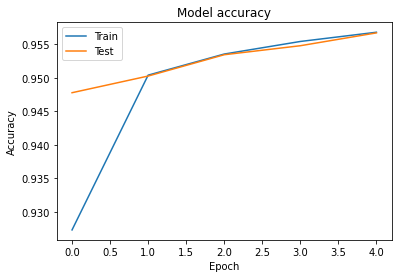

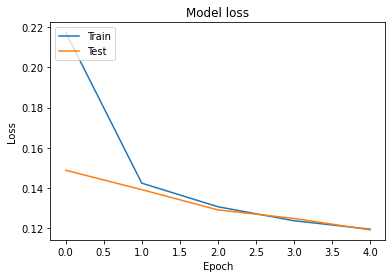

In [20]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Prediction

We can get the predictions for the validation data and check the confusion matrix to see the model's performance for each of the 5 classes. As `predict` method returns us the n-d array for probabilities for each class which we convert to class labels using `np.argmax`.

In [21]:
y_pred = model.predict(validation_data)

In [22]:
y_pred = np.argmax(y_pred, axis=1)

In [23]:
samples = file_paths[0:3]
for i, sample in enumerate(samples):
  f = open(sample)
  text = f.read()
  print(text[0:100])
  print("True Class: ", sample.split("/")[0])
  print("Predicted Class: ", dir_names[y_pred[i]])
  f.close()
  


বাংলা বর্ষ ১৪২২ বিদায় এবং নববর্ষ ১৪২৩ উদ্‌যাপন উপলক্ষে বাংলাদেশ জাতীয় জাদুঘর তিন দিনব্যাপী লোকজ ম
True Class:  entertainment
Predicted Class:  state

শেরপুরের ঝিনাইগাতী সীমান্তে ফের বন্য হাতির আক্রমণে উত্তম মারাক (৫৫) নামের এক কৃষক নিহত হয়েছেন। নিহত
True Class:  state
Predicted Class:  state

আর্জেন্টিনার খেলা চলছে। চিলির মোটেল ফ্যান্টাসিয়ায় তিল ধারণের ঠাঁই নেই। সবাই অপেক্ষা করে আছেন, কখন 
True Class:  sports
Predicted Class:  state


## Compare Performance

Now we can take the correct labels for the validation data from `labels`  and compare it with our predictions to get the [classification_report](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html). 

In [24]:
y_true = np.array(labels[train_size:])

In [25]:
print(classification_report(y_true, y_pred, target_names=dir_names))

               precision    recall  f1-score   support

      economy       0.84      0.75      0.79      3897
       sports       0.99      0.98      0.99     10204
entertainment       0.91      0.94      0.92      6256
        state       0.97      0.98      0.97     48512
international       0.94      0.92      0.93      6377

     accuracy                           0.96     75246
    macro avg       0.93      0.91      0.92     75246
 weighted avg       0.96      0.96      0.96     75246



We can also compare our model's performance with the published results obtained in the original [paper](https://www.researchgate.net/publication/328214545_BARD_Bangla_Article_Classification_Using_a_New_Comprehensive_Dataset) who report a 0.96 precision .The original authors described many preprocessing steps done on the dataset like dropping punctuations and digits, removing top 25 most frequest stop words. As we can see in the classification_report, we also gain a 0.96 precision and accuracy after training only 5 epochs without any preprocessing! 

In this example when we created the Keras layer from our embedding module we set `trainable=False`, which means the embedding weights will not be updated during training. Try setting it to True to reach 97% accuracy with this dataset with only 2 epochs. 